# <span style="color:#2F5D62"> <center> DSIM, Assignment 5 - AA 2020/2021 </center>

> <span style="color:#5E8B7E">**Studente**:</span> Campironi Matteo
>
> <span style="color:#5E8B7E">**Matricola**:</span> 801850

Implement a classification script based on the fine tuning of a neural network for the 101 object classes dataset, following the guidelines shown in the notebook.

Verify the impact over the model performance given by:
1. A different architecture (i.e. no mobile net)
2. Data augmentation operations

### <span style="color:#2F5D62"> Importo le librerie

In [1]:
from tensorflow import keras

from tensorflow.keras.applications import mobilenet_v2

from keras.applications.densenet import DenseNet121
from keras.applications.densenet import preprocess_input as preprocess_input_densenet

import numpy as np
import tarfile
from time import time
from shutil import copyfile
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

Using TensorFlow backend.


In [2]:
def modelPlots(hist):
    fig = plt.figure(figsize=(20,5))

    fig.add_subplot(1,2,1)
    plt.plot(hist.history['accuracy'], c='#f5b461')
    plt.plot(hist.history['val_accuracy'], c='#9ad3bc')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right')

    fig.add_subplot(1,2,2)
    plt.plot(hist.history['loss'], c='#f3eac2')
    plt.plot(hist.history['val_loss'], c='#ec524b')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

In [3]:
base_path = '101_ObjectCategories_split/'

# <span style="color:#2F5D62"> 1. MobileNetV2

Per prima cosa alleno un modello basato su MobileNetV2, in modo tale da poter confrontare i risulati con modelli che si basano su architetture diverse.

In [4]:
# Image transformations
train_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=mobilenet_v2.preprocess_input)
train_generator = train_processing.flow_from_directory(
        directory=base_path+'train',
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
        seed=1)

Found 4600 images belonging to 102 classes.


In [5]:
test_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=mobilenet_v2.preprocess_input)
test_generator = test_processing.flow_from_directory(
        directory=base_path+'test',
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=32,
        class_mode="categorical",
        shuffle=True
)

Found 4544 images belonging to 102 classes.


In [6]:
base_net = mobilenet_v2.MobileNetV2(input_shape=(224,224,3), weights='imagenet', include_top=False, pooling='avg')

In [7]:
for layer in base_net.layers:
    layer.trainable = False

# Output of the base model
x = base_net.output
# New intermediate fully-connected layer + ReLU
x = keras.layers.Dense(1024, activation='relu')(x)
# New (final) fully-connected layer + SoftMax activation
pred = keras.layers.Dense(102, activation='softmax')(x)

net = keras.Model(inputs=base_net.input, outputs=pred)

In [8]:
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(),
            metrics=['accuracy'])

net.fit(train_generator,
          epochs=10,
          validation_data=test_generator);

Epoch 1/10
144/144 [==============================] - 26s 180ms/step - loss: 1.3419 - accuracy: 0.7161 - val_loss: 0.4713 - val_accuracy: 0.8770
Epoch 2/10
144/144 [==============================] - 19s 133ms/step - loss: 0.2689 - accuracy: 0.9241 - val_loss: 0.3849 - val_accuracy: 0.8996
Epoch 3/10
144/144 [==============================] - 19s 131ms/step - loss: 0.1270 - accuracy: 0.9652 - val_loss: 0.5264 - val_accuracy: 0.8715
Epoch 4/10
144/144 [==============================] - 19s 135ms/step - loss: 0.0872 - accuracy: 0.9741 - val_loss: 0.5619 - val_accuracy: 0.8798
Epoch 5/10
144/144 [==============================] - 20s 139ms/step - loss: 0.0777 - accuracy: 0.9807 - val_loss: 0.6094 - val_accuracy: 0.8761
Epoch 6/10
144/144 [==============================] - 20s 139ms/step - loss: 0.0539 - accuracy: 0.9863 - val_loss: 0.7170 - val_accuracy: 0.8783
Epoch 7/10
144/144 [==============================] - 20s 137ms/step - loss: 0.0463 - accuracy: 0.9887 - val_loss: 0.5670 - val_ac

In [9]:
net.evaluate(test_generator)

142/142 [==============================] - 10s 68ms/step - loss: 0.6231 - accuracy: 0.9049


[0.6230586171150208, 0.9049295783042908]

# <span style="color:#2F5D62"> 2. DenseNet121

Scelgo come nuova architettura DenseNet121. Creo dei nuovi generatori che utilizzano la `preprocessing_function` di DenseNet.

In [10]:
train_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function = preprocess_input_densenet)

train_generator = train_processing.flow_from_directory('101_ObjectCategories_split/train/',
                        target_size = (224, 224),
                        color_mode = 'rgb',
                        class_mode = 'categorical',
                        batch_size = 32,
                        shuffle = True,
                        seed = 1)

Found 4600 images belonging to 102 classes.


In [11]:
test_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function = preprocess_input_densenet)
test_generator = test_processing.flow_from_directory('101_ObjectCategories_split/test/',
                        target_size = (224, 224),
                        color_mode = 'rgb',
                        class_mode = 'categorical',
                        batch_size = 32,
                        shuffle = True,
                        seed = 1)

Found 4544 images belonging to 102 classes.


Carico DenseNet121

In [12]:
base_net = keras.applications.DenseNet121(input_shape=(224,224,3), weights='imagenet', include_top=False, pooling='avg')

In [13]:
for layer in base_net.layers:
    layer.trainable = False

x = base_net.output
x = keras.layers.Dense(1024, activation='relu')(x)
pred = keras.layers.Dense(102, activation='softmax')(x)

net = keras.Model(inputs=base_net.input, outputs=pred)

In [14]:
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(),
            metrics=['accuracy'])

hist = net.fit(train_generator,
          epochs=10,
          validation_data=test_generator);

Epoch 1/10
144/144 [==============================] - 65s 450ms/step - loss: 1.3190 - accuracy: 0.7002 - val_loss: 0.4756 - val_accuracy: 0.8636
Epoch 2/10
144/144 [==============================] - 38s 264ms/step - loss: 0.3149 - accuracy: 0.9000 - val_loss: 0.4091 - val_accuracy: 0.8790
Epoch 3/10
144/144 [==============================] - 38s 266ms/step - loss: 0.1581 - accuracy: 0.9509 - val_loss: 0.5283 - val_accuracy: 0.8735
Epoch 4/10
144/144 [==============================] - 38s 267ms/step - loss: 0.1127 - accuracy: 0.9657 - val_loss: 0.3998 - val_accuracy: 0.8974
Epoch 5/10
144/144 [==============================] - 38s 267ms/step - loss: 0.0833 - accuracy: 0.9776 - val_loss: 0.4428 - val_accuracy: 0.8979
Epoch 6/10
144/144 [==============================] - 39s 269ms/step - loss: 0.0676 - accuracy: 0.9843 - val_loss: 0.3362 - val_accuracy: 0.9221
Epoch 7/10
144/144 [==============================] - 39s 269ms/step - loss: 0.0546 - accuracy: 0.9841 - val_loss: 0.4169 - val_ac

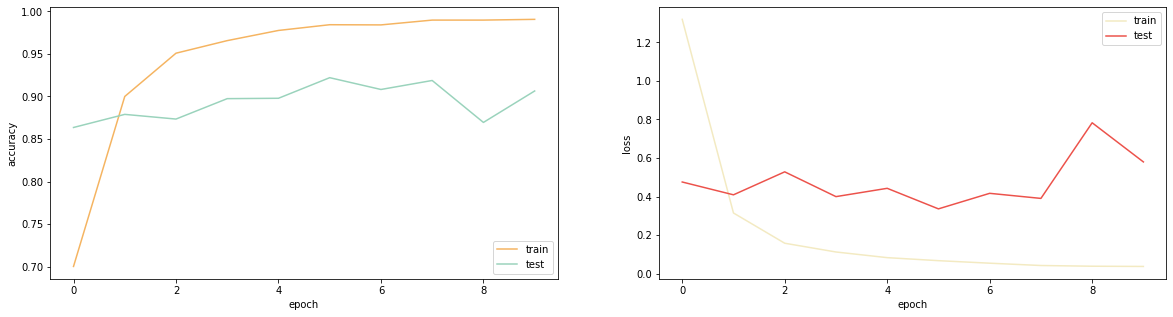

In [15]:
modelPlots(hist)

In [16]:
net.evaluate(test_generator)

142/142 [==============================] - 19s 136ms/step - loss: 0.5797 - accuracy: 0.9065


[0.5796903371810913, 0.9064700603485107]

È possibile osservare che l'accuracy sul test non si discosti molto dal modello basato su MobileNetV2, ma comunque sia presente overfitting nel modello.

# <span style="color:#2F5D62"> 3. DenseNet121 con Data Augmentation

Aggiungo delle tecniche di data augmentation al generatore precedente. Queste verranno applicate solamente al dataset di training:

In [17]:
train_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function = preprocess_input_densenet,
                                      rotation_range = 45,
                                      width_shift_range = .2,
                                      height_shift_range = .2,
                                      horizontal_flip = True,
                                      zoom_range = .2)

train_generator = train_processing.flow_from_directory('101_ObjectCategories_split/train/',
                        target_size = (224, 224),
                        color_mode = 'rgb',
                        class_mode = 'categorical',
                        batch_size = 32,
                        shuffle = True,
                        seed = 1)

Found 4600 images belonging to 102 classes.


In [18]:
test_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function = preprocess_input_densenet)
test_generator = test_processing.flow_from_directory('101_ObjectCategories_split/test/',
                        target_size = (224, 224),
                        color_mode = 'rgb',
                        class_mode = 'categorical',
                        batch_size = 32,
                        shuffle = True,
                        seed = 1)

Found 4544 images belonging to 102 classes.


In [19]:
base_net = keras.applications.DenseNet121(input_shape=(224,224,3), weights='imagenet', include_top=False, pooling='avg')

In [20]:
for layer in base_net.layers:
    layer.trainable = False

x = base_net.output
x = keras.layers.Dense(1024, activation='relu')(x)
pred = keras.layers.Dense(102, activation='softmax')(x)

net = keras.Model(inputs=base_net.input, outputs=pred)

In [21]:
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(),
            metrics=['accuracy'])

hist = net.fit(train_generator,
          epochs=10,
          validation_data=test_generator);

Epoch 1/10
144/144 [==============================] - 62s 427ms/step - loss: 1.9309 - accuracy: 0.5717 - val_loss: 0.7207 - val_accuracy: 0.7898
Epoch 2/10
144/144 [==============================] - 59s 412ms/step - loss: 0.6860 - accuracy: 0.7985 - val_loss: 0.5764 - val_accuracy: 0.8360
Epoch 3/10
144/144 [==============================] - 60s 417ms/step - loss: 0.4555 - accuracy: 0.8578 - val_loss: 0.4801 - val_accuracy: 0.8592
Epoch 4/10
144/144 [==============================] - 60s 414ms/step - loss: 0.3445 - accuracy: 0.8952 - val_loss: 0.4966 - val_accuracy: 0.8757
Epoch 5/10
144/144 [==============================] - 60s 417ms/step - loss: 0.2887 - accuracy: 0.9085 - val_loss: 0.4184 - val_accuracy: 0.8935
Epoch 6/10
144/144 [==============================] - 60s 414ms/step - loss: 0.2571 - accuracy: 0.9185 - val_loss: 0.4746 - val_accuracy: 0.8818
Epoch 7/10
144/144 [==============================] - 59s 412ms/step - loss: 0.2318 - accuracy: 0.9311 - val_loss: 0.4250 - val_ac

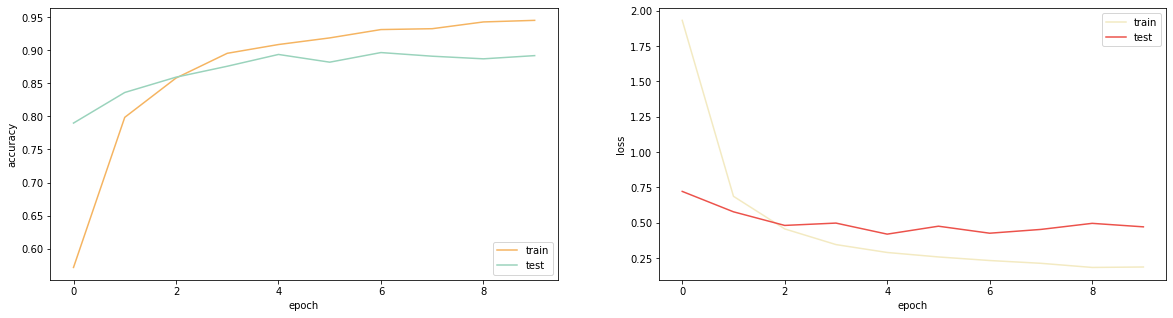

In [22]:
modelPlots(hist)

In [23]:
net.evaluate(test_generator)

142/142 [==============================] - 19s 133ms/step - loss: 0.4700 - accuracy: 0.8917


[0.47002550959587097, 0.8917253613471985]

Come è possibile osservare l'accuracy sul test è leggermente calata, ma le tecniche di data augmentation hanno reso il training set più vario, riducendo l'overfitting che colpiva i modelli precedenti.